<a href="https://colab.research.google.com/github/nguyentheanh17112002/PedestrianDetectionandSegmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ad5c10588eb12d5bec68d1143f2f1e029b8b27b07d11ed51ed23cf2551558205
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=b198eba3fdc2508c31bfd483ac6a4

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.74 MiB/s, done.
Resolving deltas: 100% (3/3), done.


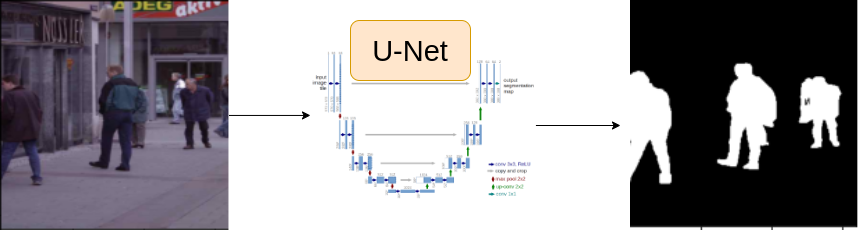

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[17]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

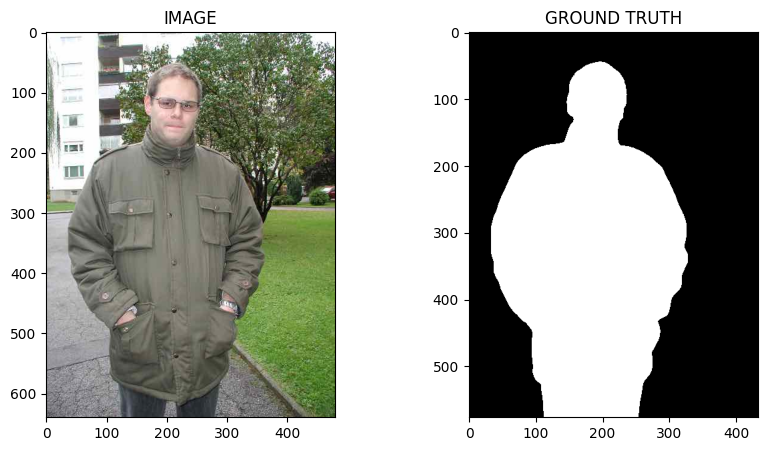

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p= 0.5),
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


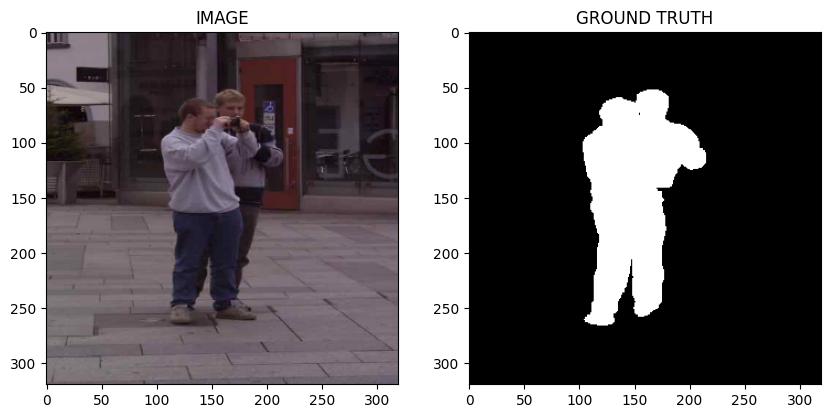

In [16]:
idx = 10

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True )
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss_fn = nn.BCEWithLogitsLoss()
      loss2 = loss_fn(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 65.5MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()

    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [25]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if(valid_loss < best_valid_loss):
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved-model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train loss: {train_loss} Valid loss: {valid_loss}")

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Saved-model
Epoch : 1 Train loss: 0.7309002776940664 Valid loss: 0.8460606336593628


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 2 Train loss: 0.3239655484755834 Valid loss: 0.9529378712177277


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Saved-model
Epoch : 3 Train loss: 0.2925238241751989 Valid loss: 0.31663214415311813


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 4 Train loss: 0.29255462686220807 Valid loss: 0.5268990024924278


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Saved-model
Epoch : 5 Train loss: 0.32970854739348093 Valid loss: 0.28117798268795013


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Saved-model
Epoch : 6 Train loss: 0.30485234757264457 Valid loss: 0.26701030135154724


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Saved-model
Epoch : 7 Train loss: 0.23173724313577015 Valid loss: 0.2107902206480503


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 8 Train loss: 0.172178149720033 Valid loss: 0.2223922312259674


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 9 Train loss: 0.17966388861338298 Valid loss: 0.21317839995026588


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Saved-model
Epoch : 10 Train loss: 0.14969104081392287 Valid loss: 0.19228384271264076


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


Saved-model
Epoch : 11 Train loss: 0.20064478615919748 Valid loss: 0.19165653362870216


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Saved-model
Epoch : 12 Train loss: 0.16366094450155894 Valid loss: 0.1823301576077938


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Saved-model
Epoch : 13 Train loss: 0.14876678436994553 Valid loss: 0.18121231719851494


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch : 14 Train loss: 0.15497397432724636 Valid loss: 0.20937055721879005


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 15 Train loss: 0.14967980831861497 Valid loss: 0.20398231595754623


100%|██████████| 4/4 [00:01<00:00,  3.74it/s]


Epoch : 16 Train loss: 0.11664612541596095 Valid loss: 0.2025950588285923


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch : 17 Train loss: 0.11721274157365164 Valid loss: 0.20562157407402992


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Saved-model
Epoch : 18 Train loss: 0.13089176416397094 Valid loss: 0.18108626082539558


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 19 Train loss: 0.1475117767850558 Valid loss: 0.19701900333166122


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch : 20 Train loss: 0.16320645809173584 Valid loss: 0.21804720163345337


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch : 21 Train loss: 0.1369229957461357 Valid loss: 0.22451985254883766


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Saved-model
Epoch : 22 Train loss: 0.11808995554844538 Valid loss: 0.1793514359742403


100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


Epoch : 23 Train loss: 0.10413383742173513 Valid loss: 0.23473840206861496


100%|██████████| 4/4 [00:01<00:00,  3.83it/s]


Epoch : 24 Train loss: 0.09126300563414892 Valid loss: 0.21114810556173325


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

Epoch : 25 Train loss: 0.10499098002910615 Valid loss: 0.188203327357769


# Task 9 : Inference

In [30]:
idx = 6
model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

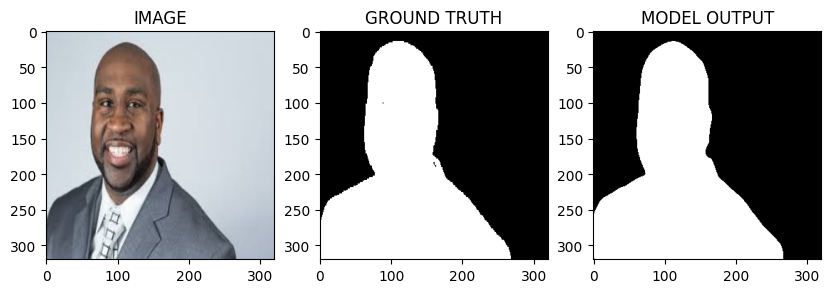

In [31]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya